In [219]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from nltk.stem.snowball import SnowballStemmer
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from os import path
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import scale
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer
from scipy.sparse import csr_matrix

In [245]:
df = pd.read_json('~/Metis/projects/04-fletcher/.gitignore/files/projects.json')

In [242]:
characters = ["'ll","'re","'s","'ve","n't",]
common_words = ['Kickstarter','kickstarter','kickstarterers',
                'people','like','us','year',
                'kickstarter','funding','need','project','works',
                'people','backers','one','would']
stopword_list = nltk.corpus.stopwords.words('english') + characters + common_words
stemmer = SnowballStemmer('english')

In [137]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [198]:
totalvocab_stemmed = []
totalvocab_tokenized = []
df.description.apply(lambda x: totalvocab_stemmed.extend(tokenize_and_stem(x)))
df.description.apply(lambda x: totalvocab_tokenized.extend(tokenize_only(x)))
print('Done!')

Done!


In [201]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 4248934 items in vocab_frame


In [135]:
vocab_frame.words.value_counts()[80:100]

just       5913
how        5702
first      5497
when       5471
would      5419
only       5384
play       5370
through    5247
here       5211
many       5095
story      5057
pledge     5048
any        5033
now        4982
cards      4953
work       4918
over       4911
me         4837
see        4789
'll        4743
Name: words, dtype: int64

In [243]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words=stopword_list,
                                   use_idf=True, ngram_range=(1,3),
                                   analyzer='word')

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.description) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 34.1 s, sys: 600 ms, total: 34.7 s
Wall time: 34.7 s
(6342, 115)


scipy.sparse.csr.csr_matrix

In [205]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

['abl', 'add', 'addit', 'allow', 'alreadi', 'also', 'ani', 'around', 'art', 'artist', 'ask', 'avail', 'back', 'backer', 'base', 'becaus', 'becom', 'befor', 'best', 'better', 'bring', 'campaign', 'chang', 'check', 'come', 'communiti', 'complet', 'continu', 'cost', 'could', 'cover', 'creat', 'current', 'day', 'design', 'develop', 'differ', 'documentari', 'edit', 'end', 'even', 'everi', 'everyon', 'experi', 'famili', 'featur', 'feel', 'film', 'final', 'find', 'first', 'follow', 'free', 'friend', 'full', 'fund', 'game', 'give', 'go', 'good', 'great', 'happen', 'high', 'hope', 'idea', 'import', 'includ', 'interest', 'keep', 'kickstart', 'know', 'last', 'learn', 'level', 'life', 'live', 'look', 'lot', 'love', 'made', 'make', 'mani', 'may', 'mean', 'money', 'much', 'music', 'name', 'new', 'next', 'offer', 'onc', 'onli', 'order', 'origin', 'page', 'part', 'pay', 'peopl', 'person', 'place', 'plan', 'play', 'player', 'pleas', 'pledg', 'possibl', 'produc', 'product', 'provid', 'put', 'rais', 'rea

In [240]:
dist = 1 - cosine_similarity(tfidf_matrix)
print(type(dist))
print

<class 'numpy.ndarray'>


<function print>

In [246]:
for i in range(5,16):
    num_clusters = i
    print('Number of Clusters:\t'+str(num_clusters)+'\n\n')
    km = KMeans(n_clusters=num_clusters,n_jobs=-1)
    %time km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    df = pd.concat([df,pd.DataFrame(clusters,columns=['clusters'])],axis=1)
    print('\nValue Counts:\n'+str(df.clusters.value_counts())+'\n')
    print('Top terms per cluster:\n')
    order_centroids = km.cluster_centers_.argsort()[:,::-1]
    for i in range(num_clusters):
        print('\nCluster %d words:' %i,end='')
        for ind in order_centroids[i,:10]:
            print(' %s ' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    df.drop('clusters',axis=1,inplace=True)
    print('\n\n\n\n')

Number of Clusters:	5


CPU times: user 700 ms, sys: 428 ms, total: 1.13 s
Wall time: 33.8 s

Value Counts:
0    2757
1    1334
2    1165
4    654 
3    432 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: finally , pledge , knows , every , reach , also , hope , people , producing , gives ,
Cluster 1 words: currently , made , community , once , finally , hope , reach , gives , family , interests ,
Cluster 2 words: end , even , living , allow , knows , every , lot , also , around , game ,
Cluster 3 words: becomes , really , currently , created , finally , community , knows , reach , producing , kickstarter ,
Cluster 4 words: kickstarter , knows , finally , people , reach , put , also , receive , important , production ,




Number of Clusters:	6


CPU times: user 704 ms, sys: 376 ms, total: 1.08 s
Wall time: 30.5 s

Value Counts:
3    2534
5    1316
2    1041
4    642 
1    440 
0    369 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: all

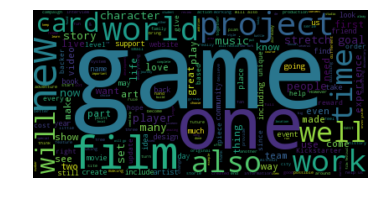

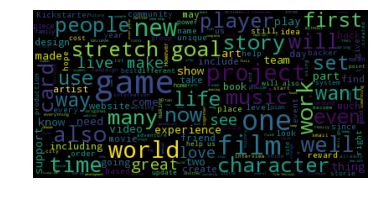

In [153]:
from os import path
from wordcloud import WordCloud
# Read the whole text.
text = ' '.join(df.description)

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Risks Analysis

In [181]:
riskvocab_stemmed = []
riskvocab_tokenized = []
df.risks.apply(lambda x: riskvocab_stemmed.extend(tokenize_and_stem(x)))
df.risks.apply(lambda x: riskvocab_tokenized.extend(tokenize_only(x)))
print('Done!')

Done!


In [182]:
riskvocab_frame = pd.DataFrame({'words': riskvocab_tokenized}, index = riskvocab_stemmed)
print('there are ' + str(riskvocab_frame.shape[0]) + ' items in vocab_frame')

there are 641668 items in vocab_frame


In [183]:
risk_tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stopword_list,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3),
                                  analyzer='word')

%time risk_tfidf_matrix = risk_tfidf_vectorizer.fit_transform((df.risks.str.replace('Risks and challenges ','').str.replace(' Learn about accountability on Kickstarter',''))) #fit the vectorizer to synopses

print(risk_tfidf_matrix.shape)

CPU times: user 21.3 s, sys: 8 ms, total: 21.3 s
Wall time: 21.3 s
(6342, 6)


In [184]:
terms = risk_tfidf_vectorizer.get_feature_names()
print(terms)

['challeng', 'make', 'product', 'risk', 'time', 'work']


In [185]:
for i in range(5,16):
    num_clusters = i
    print('Number of Clusters:\t'+str(num_clusters)+'\n\n')
    km = KMeans(n_clusters=num_clusters,n_jobs=-1)
    %time km.fit(risk_tfidf_matrix)
    clusters = km.labels_.tolist()
    df = pd.concat([df,pd.DataFrame(clusters,columns=['clusters'])],axis=1)
    print('\nValue Counts:\n'+str(df.clusters.value_counts())+'\n')
    print('Top terms per cluster:\n')
    order_centroids = km.cluster_centers_.argsort()[:,::-1]
    for i in range(num_clusters):
        print('\nCluster %d words:' %i,end='')
        for ind in order_centroids[i,:10]:
            print(' %s ' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    df.drop('clusters',axis=1,inplace=True)
    print('\n\n\n\n')

Number of Clusters:	5


CPU times: user 256 ms, sys: 344 ms, total: 600 ms
Wall time: 958 ms

Value Counts:
0    2580
3    1024
2    1023
4    942 
1    773 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: make , works , risk , challenges , production , time ,
Cluster 1 words: challenges , make , works , risk , production , time ,
Cluster 2 words: time , works , make , challenges , risk , production ,
Cluster 3 words: risk , challenges , make , works , time , production ,
Cluster 4 words: production , works , make , time , risk , challenges ,




Number of Clusters:	6


CPU times: user 228 ms, sys: 332 ms, total: 560 ms
Wall time: 1.02 s

Value Counts:
1    2226
4    1035
2    846 
3    819 
0    743 
5    673 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: make , challenges , risk , time , works , production ,
Cluster 1 words: works , time , risk , production , make , challenges ,
Cluster 2 words: risk , challenges , time , works , make

CPU times: user 216 ms, sys: 340 ms, total: 556 ms
Wall time: 1.12 s

Value Counts:
0     2226
10    430 
5     420 
2     414 
7     392 
9     370 
11    306 
4     296 
6     276 
12    260 
8     255 
3     250 
13    225 
1     222 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: works , time , risk , production , make , challenges ,
Cluster 1 words: make , challenges , works , time , production , risk ,
Cluster 2 words: risk , production , works , time , make , challenges ,
Cluster 3 words: production , time , challenges , risk , works , make ,
Cluster 4 words: works , time , make , production , challenges , risk ,
Cluster 5 words: time , challenges , works , make , production , risk ,
Cluster 6 words: challenges , risk , works , production , time , make ,
Cluster 7 words: production , risk , works , time , challenges , make ,
Cluster 8 words: production , make , works , time , challenges , risk ,
Cluster 9 words: works , challenges , risk , make , product

In [ ]:
Risk-Related 1: make , works , risk , challenges , production , time ,
Risk-Related 2: challenges , make , works , risk , production , time ,
Risk-Related 3: time , works , make , challenges , risk , production ,
Risk-Related 4: risk , challenges , make , works , time , production ,
Risk-Related 5: production , works , make , time , risk , challenges ,

In [239]:
for i in range(7,10):
    num_clusters = i
    pca = PCA(n_components=num_clusters).fit(tfidf_matrix.todense())
    print('Number of Clusters:\t'+str(num_clusters)+'\n\n')
    km = KMeans(init=pca.components_,n_clusters=num_clusters,n_jobs=-1)
    %time km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    df = pd.concat([df,pd.DataFrame(clusters,columns=['clusters'])],axis=1)
    print('\nValue Counts:\n'+str(df.clusters.value_counts())+'\n')
    print('Top terms per cluster:\n')
    order_centroids = km.cluster_centers_.argsort()[:,::-1]
    for i in range(num_clusters):
        print('\nCluster %d words:' %i,end='')
        for ind in order_centroids[i,:10]:
            print(' %s ' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    df.drop('clusters',axis=1,inplace=True)
    print('\n\n\n\n')

Number of Clusters:	7




/home/brendanfitzpatrick/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


CPU times: user 1.22 s, sys: 460 ms, total: 1.68 s
Wall time: 8.79 s

Value Counts:
6    1681
1    1284
0    1043
5    905 
2    638 
3    424 
4    367 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: end , even , learned , interests , allow , also , greatly , around , page , providing ,
Cluster 1 words: currently , looking , community , new , greatly , providing , full , idea , also , becomes ,
Cluster 2 words: including , interests , page , providing , producing , also , raised , designed , pledge , highly ,
Cluster 3 words: becomes , put , currently , created , community , interests , providing , planning , level , including ,
Cluster 4 words: allow , life , end , many , friend , even , interests , art , add , able ,
Cluster 5 words: please , playing , providing , greatly , also , best , follow , page , idea , may ,
Cluster 6 words: interests , community , new , page , full , providing , planning , raised , also , producing ,




Number of Clusters:	8




/home/brendanfitzpatrick/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


CPU times: user 1.23 s, sys: 420 ms, total: 1.65 s
Wall time: 7.76 s

Value Counts:
7    1834
0    1033
1    1028
6    767 
2    633 
3    389 
4    369 
5    289 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: end , even , learned , interests , allow , also , around , greatly , page , providing ,
Cluster 1 words: currently , looking , new , community , greatly , providing , idea , becomes , also , full ,
Cluster 2 words: including , interests , page , producing , providing , also , raised , pledge , designed , highly ,
Cluster 3 words: becomes , put , currently , created , interests , please , providing , including , level , producing ,
Cluster 4 words: allow , life , end , many , friend , even , interests , art , add , able ,
Cluster 5 words: planning , also , page , interests , greatly , providing , funding , next , playing , producing ,
Cluster 6 words: community , currently , new , looking , full , providing , raised , interests , page , greatly ,
Cluster 

/home/brendanfitzpatrick/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


CPU times: user 1.23 s, sys: 448 ms, total: 1.68 s
Wall time: 17.2 s

Value Counts:
8    1757
1    1124
0    1035
2    615 
6    465 
3    368 
4    361 
7    347 
5    270 
Name: clusters, dtype: int64

Top terms per cluster:


Cluster 0 words: end , even , learned , interests , allow , also , around , greatly , page , providing ,
Cluster 1 words: currently , looking , new , community , greatly , providing , idea , full , also , becomes ,
Cluster 2 words: including , interests , providing , producing , also , page , raised , designed , pledge , highly ,
Cluster 3 words: becomes , put , currently , created , interests , providing , including , level , next , producing ,
Cluster 4 words: allow , life , end , many , friend , even , interests , art , add , able ,
Cluster 5 words: planning , also , interests , page , greatly , next , providing , funding , playing , pledge ,
Cluster 6 words: community , currently , new , full , looking , providing , raised , interests , best , highly ,
Clus

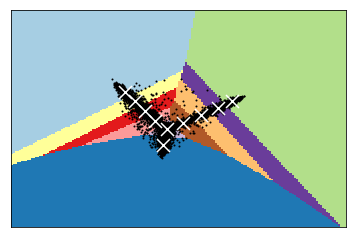

In [248]:
n_digits = 10
reduced_data = PCA(n_components=2).fit_transform(tfidf_matrix.todense())
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10,n_jobs=-1)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(()) 
plt.yticks(())
plt.show()

In [ ]:
Cluster 0 words: please , knows , music , finally , also , put , best , editing , only , go ,
Cluster 1 words: community , currently , finally , made , gives , knows , best , receive , interests , reach ,
Cluster 2 words: allow , lot , end , money , game , even , knows , every , art , add ,
Cluster 3 words: currently , once , made , gives , finally , family , hope , receive , knows , able ,
Cluster 4 words: end , even , living , knows , every , allow , also , hope , around , people ,
Cluster 5 words: currently , made , finally , community , hope , once , reach , interests , also , becomes ,
Cluster 6 words: producing , best , finally , also , pledge , knows , editing , becomes , campaign , every ,
Cluster 7 words: kickstarter , knows , finally , reach , put , people , also , receive , designed , production ,
Cluster 8 words: reach , any , finally , gives , also , people , knows , much , pledge , important ,
Cluster 9 words: pledge , every , finally , hope , people , interests , full , also , knows , feature ,
Cluster 10 words: becomes , really , currently , created , finally , knows , kickstarter , please , every , only